In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
from prophet import Prophet

In [ ]:
df = pd.read_csv('file.csv')
df.interpolate('linear',inplace = True)
print(df.isnull().sum())

measurement_date          0
upstream_water_level      0
downstream_water_level    0
inflow_rate               0
outflow_rate              0
dtype: int64


<ipython-input-5-e5f775962d75>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate('linear',inplace = True)


In [ ]:
df['measurement_date'] = pd.to_datetime(df['measurement_date'])
data = df.sort_values('measurement_date')
print(data.head())

  measurement_date  upstream_water_level  downstream_water_level  inflow_rate  \
0       2011-04-17                159.94                   64.82       6500.0   
1       2011-04-18                159.62                   65.20       6100.0   
2       2011-04-19                159.30                   64.85       5800.0   
3       2011-04-20                158.94                   64.58       5800.0   
4       2011-04-21                158.70                   65.14       6600.0   

   outflow_rate  
0        7490.0  
1        8070.0  
2        8100.0  
3        8080.0  
4        8140.0  


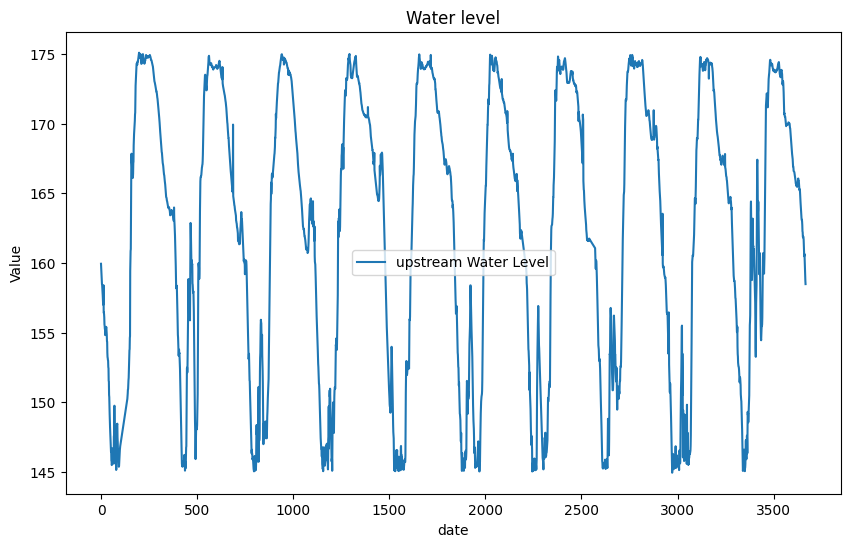

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['upstream_water_level'], label='upstream Water Level')

plt.legend()
plt.title('Water level')
plt.xlabel('date')
plt.ylabel('Value')
plt.show()

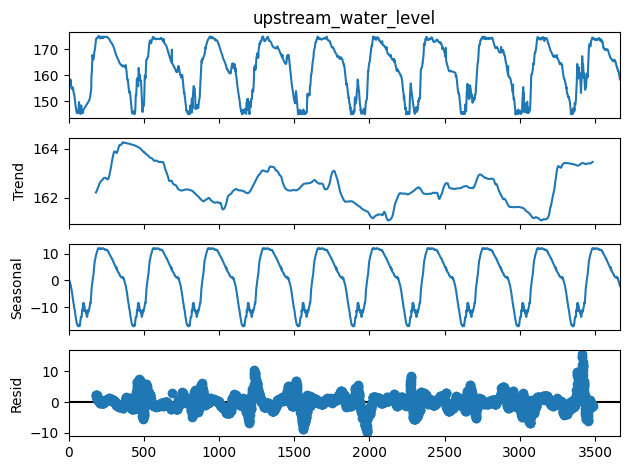

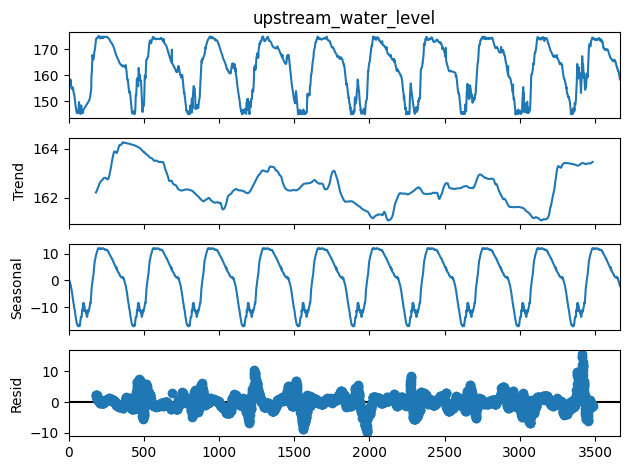

In [ ]:
x = seasonal_decompose(data['upstream_water_level'], period = 365, model = 'additive')
x.plot()


In [ ]:
train_size = int(len(df) * 0.8)
train = data[:train_size]
test = data[train_size:]


In [ ]:
df_prophet = train.rename(columns={'measurement_date': 'ds', 'upstream_water_level': 'y'})

In [ ]:
df_test = test.rename(columns={'measurement_date': 'ds', 'upstream_water_level': 'y'})

In [ ]:
df_prophet.drop(['downstream_water_level','inflow_rate','outflow_rate'],axis = 1, inplace = True)

In [ ]:
df_test.drop(['downstream_water_level','inflow_rate','outflow_rate'],axis = 1, inplace = True)

In [ ]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False)
model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpn1utzyxv/0b_r3rl_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn1utzyxv/qth0v9sh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40150', 'data', 'file=/tmp/tmpn1utzyxv/0b_r3rl_.json', 'init=/tmp/tmpn1utzyxv/qth0v9sh.json', 'output', 'file=/tmp/tmpn1utzyxv/prophet_model5ub_y_ji/prophet_model-20241122042623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:26:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:26:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)
forecast_test = forecast.iloc[-len(test):]

In [ ]:
test = test.rename(columns={'measurement_date': 'ds', 'upstream_water_level': 'y'})

In [ ]:
mse = mean_squared_error(test['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
mape = np.mean(np.abs((test['y'] - forecast_test['yhat']) / test['y'])) * 100
r2 = r2_score(test['y'], forecast_test['yhat'])

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}%")
print(f"R-squared: {r2}")

Mean Squared Error: 14.099634106206903
Root Mean Squared Error: 3.754947949866536
Mean Absolute Error: 2.853892576507802
Mean Absolute Percentage Error: 1.7839160670074543%
R-squared: 0.8540837106712946


In [ ]:
print(forecast_test['yhat'])

2933    162.144034
2934    161.925567
2935    161.692398
2936    161.444819
2937    161.183230
           ...    
3662    163.827808
3663    163.631674
3664    163.420629
3665    163.194782
3666    162.954365
Name: yhat, Length: 734, dtype: float64


In [ ]:
forecast_test['yhat'].describe()

,yhat
count,734.000000
mean,163.862445
std,10.025916
min,146.263518
25%,152.715308
50%,165.723851
75%,173.684894
max,176.216505


In [ ]:
test['y'].describe()

,y
count,734.000000
mean,162.301887
std,9.836669
min,144.940000
25%,154.435000
50%,164.590000
75%,170.842500
max,174.790000
